In [ ]:
!pip install --upgrade openpyxl

In [ ]:
!pip install pytrends

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
#importing all the required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from pytrends.request import TrendReq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
file_path = '/content/https___www.seamedu.com_-Performance-on-Search-2024-12-21.xlsx'  #importing the dataset.
Data = pd.read_excel(file_path, sheet_name=None)                                       #Fitting the dataset to pandas DataFrame.

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# Extracting the necessary sheets from the dataset.
queries = Data['Queries']
pages = Data['Pages']
date = Data['Dates']

In [ ]:
#desceibe function: Used to extract the min, max, standard deviation of the features.
print(queries.describe())
print(pages.describe())
print(date.describe())

            Clicks    Impressions          CTR     Position
count  1000.000000    1000.000000  1000.000000  1000.000000
mean     22.391000    1430.503000     0.036839    10.269030
std     141.219634    5958.851384     0.063125     9.983169
min       4.000000      20.000000     0.000400     1.000000
25%       5.000000     221.000000     0.009100     4.745000
50%       8.000000     466.000000     0.019200     7.590000
75%      16.000000    1081.000000     0.037950    10.932500
max    4278.000000  165183.000000     0.721500    74.940000
            Clicks    Impressions         CTR    Position
count   604.000000     604.000000  604.000000  604.000000
mean    138.485099   11139.157285    0.012281   29.189669
std     545.187619   31024.045403    0.016179   15.324093
min       0.000000       1.000000    0.000000    1.000000
25%       1.000000     232.250000    0.002375   17.697500
50%      11.000000    1278.000000    0.007850   27.280000
75%      76.500000    8343.000000    0.016300   37.530

In [ ]:
#info Function: used to check for null values and the datatype of the features.
print(queries.info())
print(pages.info())
print(date.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Top queries  1000 non-null   object 
 1   Clicks       1000 non-null   int64  
 2   Impressions  1000 non-null   int64  
 3   CTR          1000 non-null   float64
 4   Position     1000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Top pages    604 non-null    object 
 1   Clicks       604 non-null    int64  
 2   Impressions  604 non-null    int64  
 3   CTR          604 non-null    float64
 4   Position     604 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 23.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to

**SHOWS THERE ARE NO NULL VALUES IN THE MENTIONED SHEETS**

In [ ]:
# Data Cleaning: Filling-up the missing values with 'fillna' function, droping the duplicates or repeated values.
for sheet_name, df in Data.items():
    # Drop duplicates
    Data[sheet_name] = df.drop_duplicates()
    # Handle missing values
    Data[sheet_name] = df.fillna(method='ffill').fillna(method='bfill')

<ipython-input-13-d4a3e35a8732>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data[sheet_name] = df.fillna(method='ffill').fillna(method='bfill')


**ANALYSIS OF BRANDED AND NON-BRANDED CLICKS**

In [ ]:
# Identify Branded and Non-Branded Queries.
brand_name = "seamedu"                                               #Here we consider 'seamedu' as our brand name (English)
queries['Is_Branded'] = queries['Top queries'].str.contains(brand_name, case=False, na=False)
branded_clicks = queries[queries['Is_Branded']]['Clicks'].sum()
non_branded_clicks = queries[~queries['Is_Branded']]['Clicks'].sum()

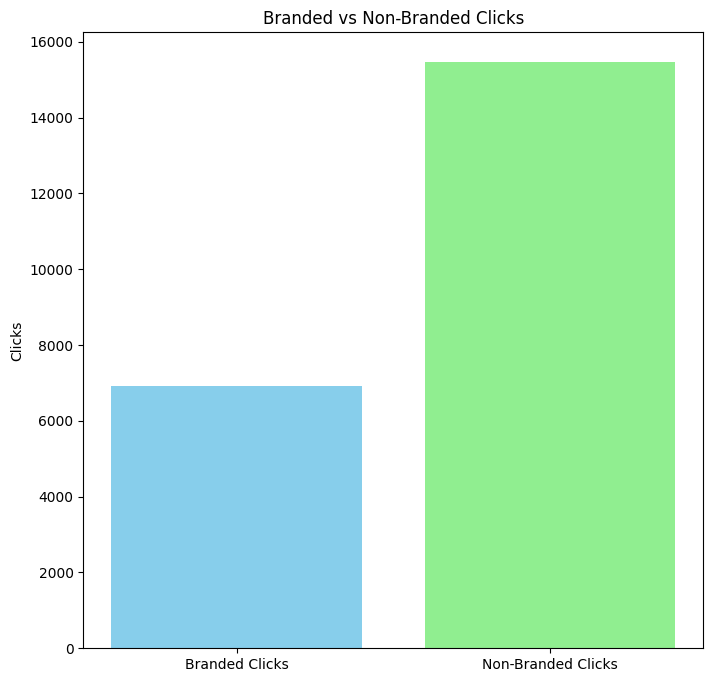

In [ ]:
# Plotting the Branded(seamedu) vs Non-Branded Clicks
plt.figure(figsize=(8, 8))
plt.bar(['Branded Clicks', 'Non-Branded Clicks'], [branded_clicks, non_branded_clicks], color=['skyblue', 'lightgreen'])
plt.title('Branded vs Non-Branded Clicks')
plt.ylabel('Clicks')
plt.show()

**ANALYSIS OF BRANDED AND NON-BRANDED IMPRESSIONS**

In [ ]:
#Identify Branded and Non-Branded Queries
queries['Is_Branded'] = queries['Top queries'].str.contains(brand_name, case=False, na=False)

# Calculating the Branded and Non-Branded Impressions from the queries sheet.
branded_impressions = queries[queries['Is_Branded']]['Impressions'].sum()
non_branded_impressions = queries[~queries['Is_Branded']]['Impressions'].sum()

# Print the results
print(f"Branded Impressions: {branded_impressions}")
print(f"Non-Branded Impressions: {non_branded_impressions}")

Branded Impressions: 20036
Non-Branded Impressions: 1410467


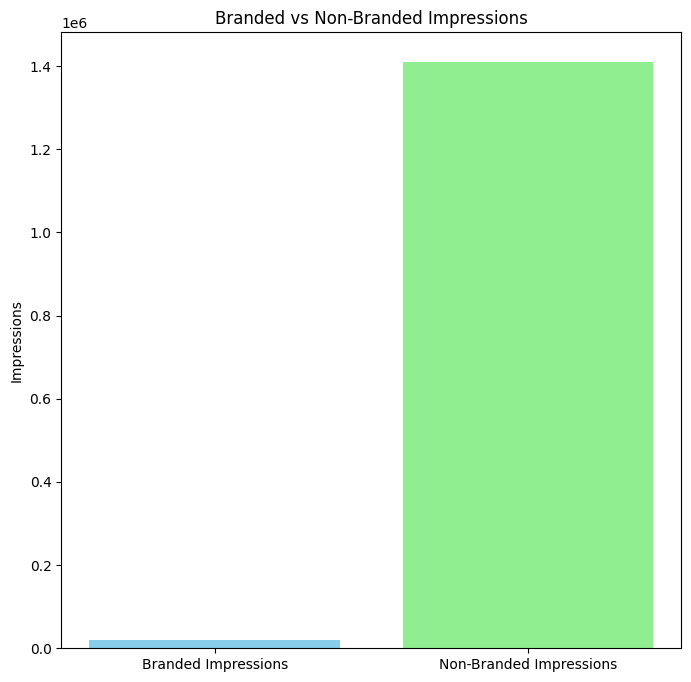

In [ ]:
# Plotting the Branded vs Non-Branded Impressions
impressions = [branded_impressions, non_branded_impressions]
labels = ['Branded Impressions', 'Non-Branded Impressions']

plt.figure(figsize=(8, 8))
plt.bar(labels, impressions, color=['skyblue', 'lightgreen'])
plt.title('Branded vs Non-Branded Impressions')
plt.ylabel('Impressions')
plt.show()

**WEEK-OF-WEEK, MONTH-OF-MONTH, YEAR-OF-YEAR CLICK ANALYSIS***

In [ ]:
# WoW, MoM, YoY Analysis
date['Date'] = pd.to_datetime(date['Date'])
date = date.sort_values('Date')
date['WoW_Clicks'] = date['Clicks'].pct_change(periods=7)
date['MoM_Clicks'] = date['Clicks'].pct_change(periods=30)
date['YoY_Clicks'] = date['Clicks'].pct_change(periods=365)


MoM Change (%)= (( Current Month Value -Previous Month Value) / Previous Month Value​)×100

WoW Change (%)= (( Current Week Value -Previous Week Value) / Previous Week Value​)×100

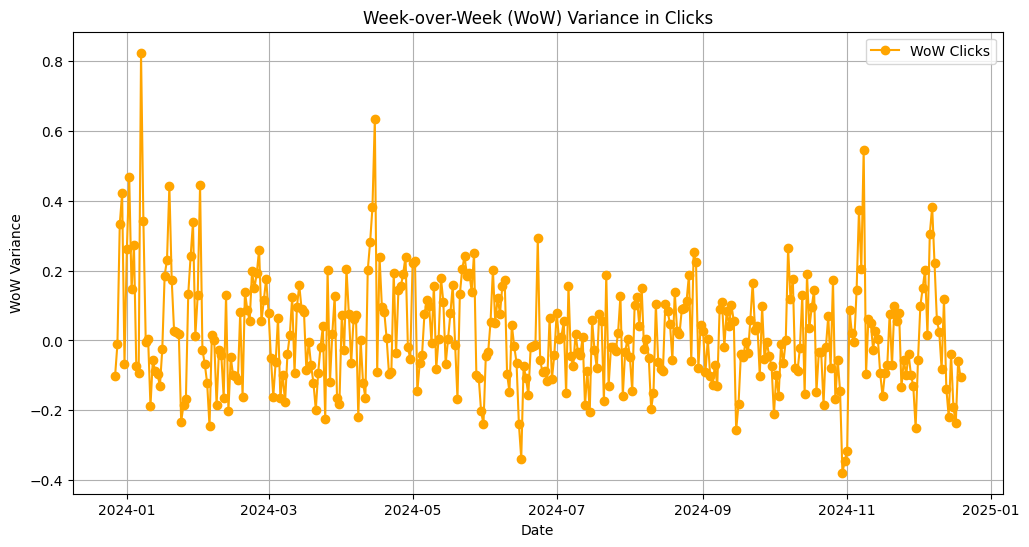

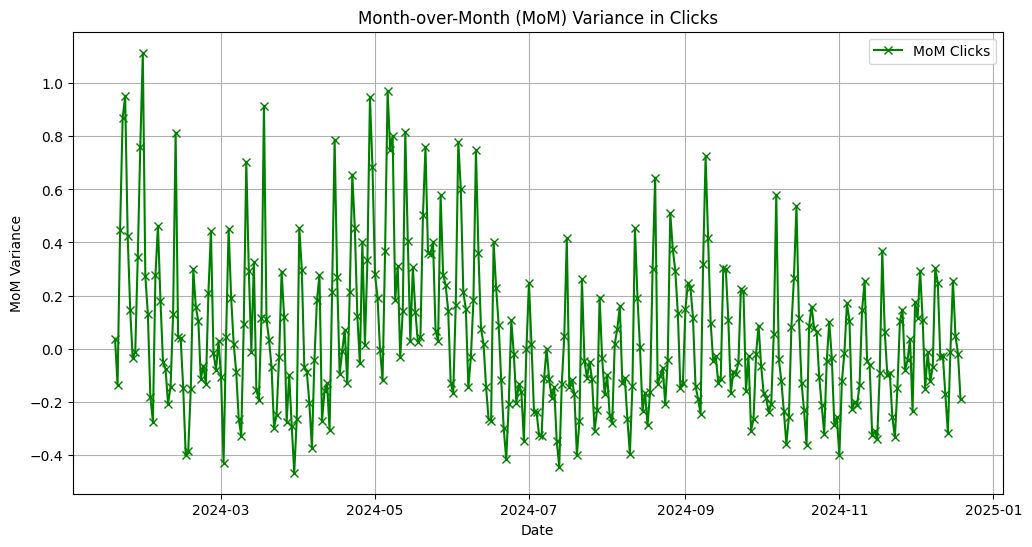

In [ ]:
# WoW Variance Visualization for clicks
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['WoW_Clicks'], label='WoW Clicks', color='orange', marker='o')
plt.title('Week-over-Week (WoW) Variance in Clicks')
plt.xlabel('Date')
plt.ylabel('WoW Variance')
plt.legend()
plt.grid(True)
plt.show()

# MoM Variance Visualization for clicks
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['MoM_Clicks'], label='MoM Clicks', color='green', marker='x')
plt.title('Month-over-Month (MoM) Variance in Clicks')
plt.xlabel('Date')
plt.ylabel('MoM Variance')
plt.legend()
plt.grid(True)
plt.show()

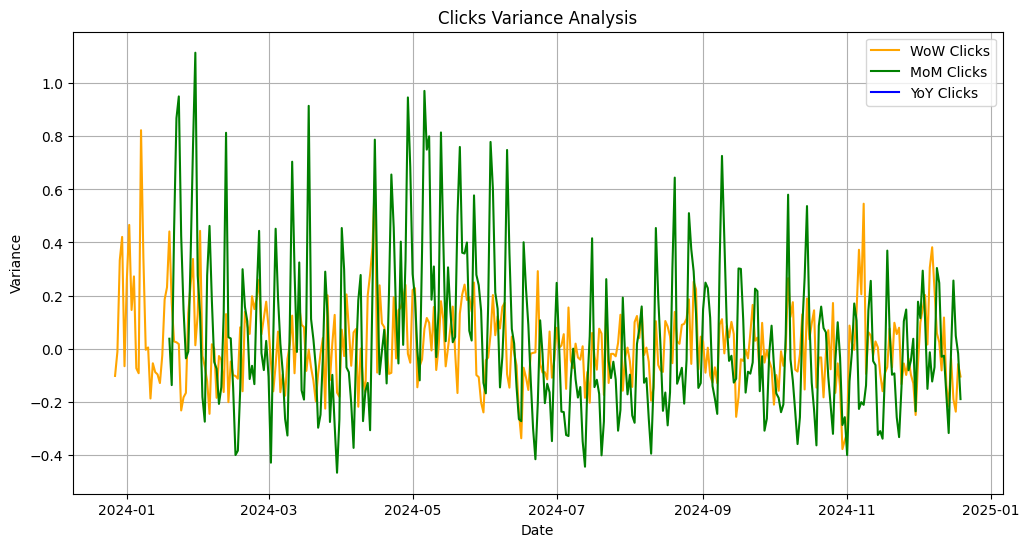

In [ ]:
# Plot Variance
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['WoW_Clicks'], label='WoW Clicks', color='orange')
plt.plot(date['Date'], date['MoM_Clicks'], label='MoM Clicks', color='green')
plt.plot(date['Date'], date['YoY_Clicks'], label='YoY Clicks', color='blue')
plt.legend()
plt.title('Clicks Variance Analysis')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

Re-checking the results manually using formula

In [ ]:
# Add a Month column for grouping
date['Month'] = date['Date'].dt.to_period('M')  # '2024-01', '2024-02', etc.
# Aggregate data by month
monthly_data = date.groupby('Month').agg({'Clicks': 'sum'}).reset_index()
#applying formula
monthly_data['MoM_Manual'] = monthly_data['Clicks'].diff() / monthly_data['Clicks'].shift(1) * 100

      Month  MoM_Manual  MoM_Automated
0   2023-12         NaN            NaN
1   2024-01  240.158730     240.158730
2   2024-02   -6.439571      -6.439571
3   2024-03    3.291771       3.291771
4   2024-04    6.116208       6.116208
5   2024-05   32.140149      32.140149
6   2024-06   -3.374656      -3.374656
7   2024-07  -10.905203     -10.905203
8   2024-08   -4.320000      -4.320000
9   2024-09   -0.975474      -0.975474
10  2024-10   -5.009851      -5.009851
11  2024-11  -12.829630     -12.829630
12  2024-12  -34.177430     -34.177430


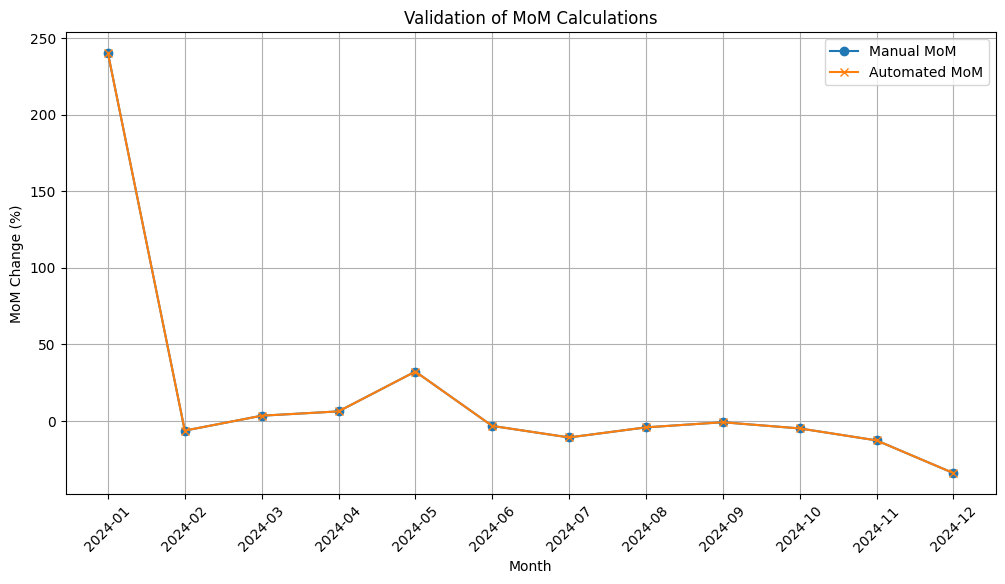

In [ ]:
# Add automated MoM calculations
monthly_data['MoM_Automated'] = monthly_data['Clicks'].pct_change() * 100
# Validate by comparing values
comparison = monthly_data[['Month', 'MoM_Manual', 'MoM_Automated']]
print(comparison)
#showing it graphically
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Month'].astype(str), monthly_data['MoM_Manual'], label='Manual MoM', marker='o')
plt.plot(monthly_data['Month'].astype(str), monthly_data['MoM_Automated'], label='Automated MoM', marker='x')
plt.title('Validation of MoM Calculations')
plt.xlabel('Month')
plt.ylabel('MoM Change (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

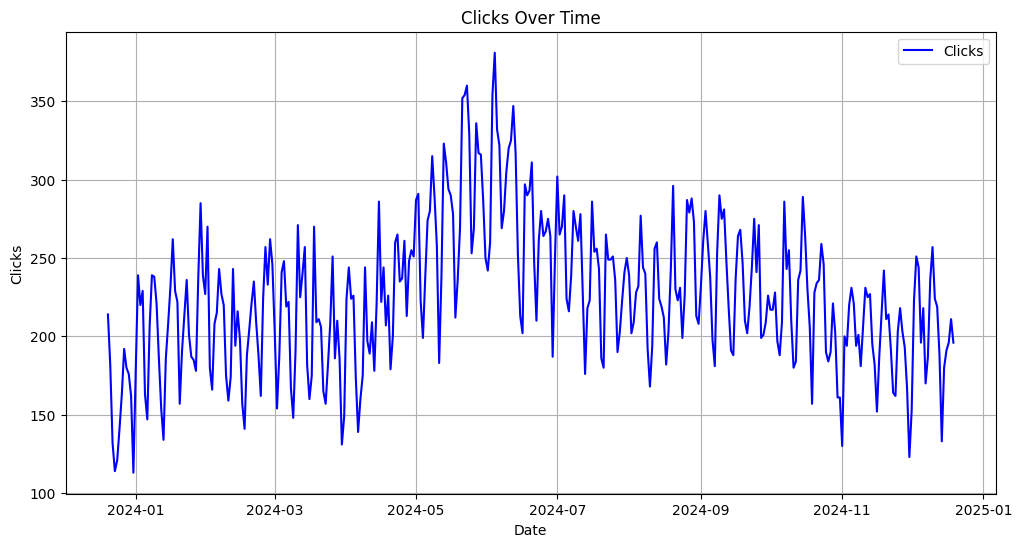

In [ ]:
# Plot Clicks Over Time(Months)
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['Clicks'], label='Clicks', color='blue')
plt.title('Clicks Over Time')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.grid(True)
plt.show()

**WOW, MOM, YOY Impressions ANALYSIS**

In [ ]:
date['WoW_Impressions'] = date['Impressions'].pct_change(periods=7)   # Week-over-Week
date['MoM_Impressions'] = date['Impressions'].pct_change(periods=30)  # Month-over-Month
date['YoY_Impressions'] = date['Impressions'].pct_change(periods=365) # Year-over-Year

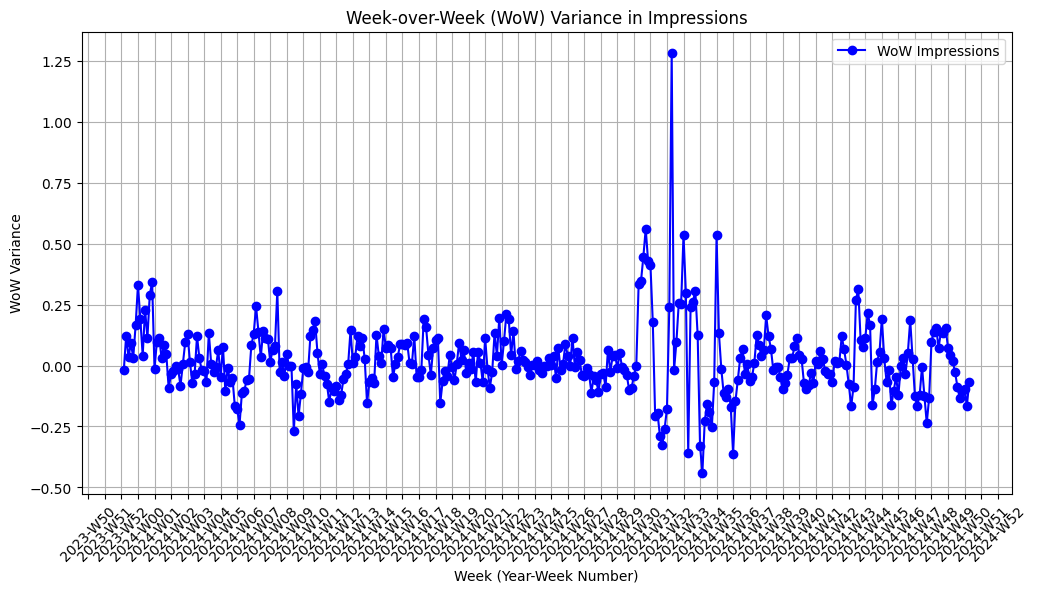

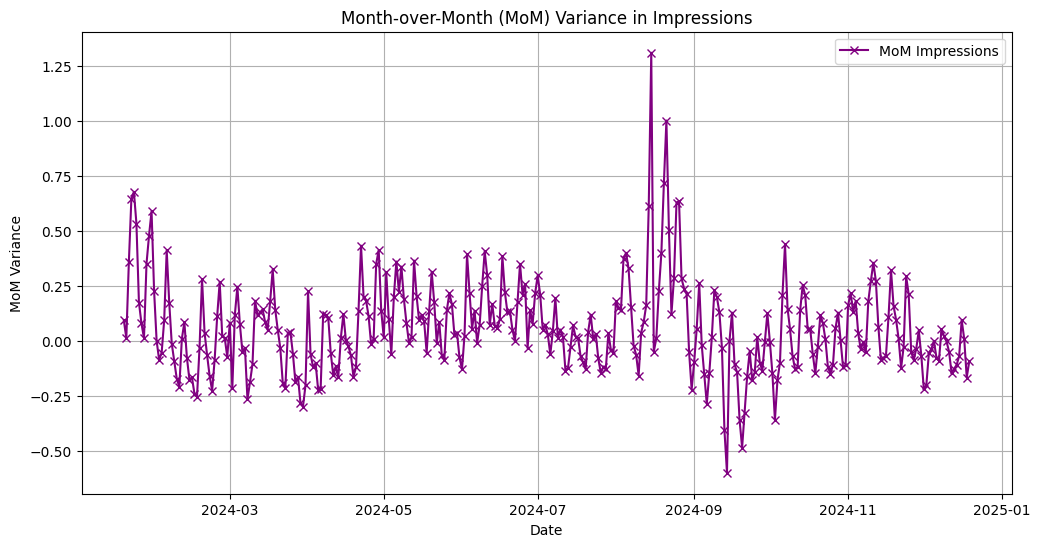

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['WoW_Impressions'], label='WoW Impressions', color='blue', marker='o')
# Format the x-axis to show week labels
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())  # Place ticks at each week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-W%U'))  # Format as Year-WeekNumber
# Add labels, title, and grid
plt.title('Week-over-Week (WoW) Variance in Impressions')
plt.xlabel('Week (Year-Week Number)')
plt.ylabel('WoW Variance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate for better readability
plt.show()

# MoM Impressions Variance Visualization
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['MoM_Impressions'], label='MoM Impressions', color='purple', marker='x')
plt.title('Month-over-Month (MoM) Variance in Impressions')
plt.xlabel('Date')
plt.ylabel('MoM Variance')
plt.legend()
plt.grid(True)
plt.show()

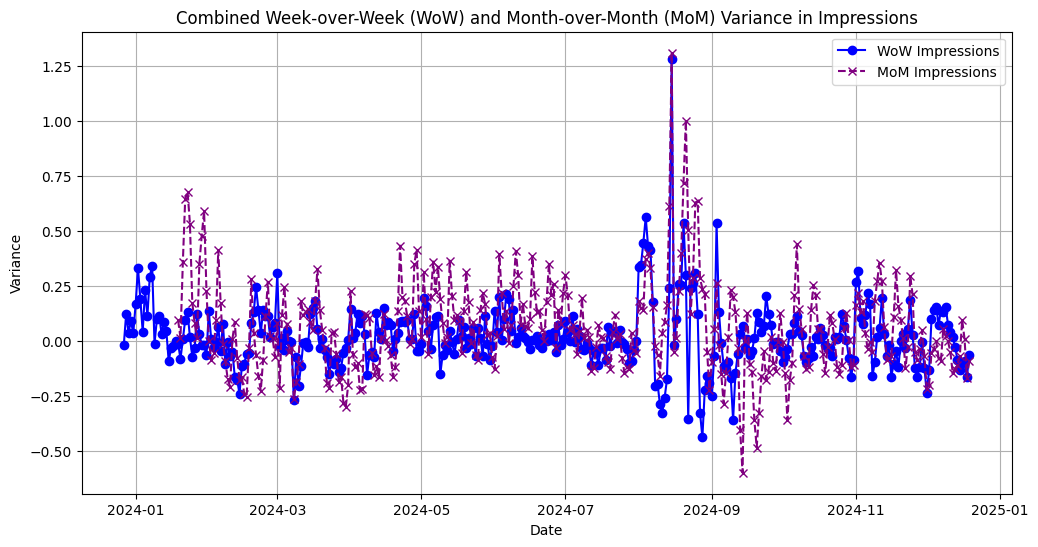

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date['Date'], date['WoW_Impressions'], label='WoW Impressions', color='blue', marker='o', linestyle='-')
plt.plot(date['Date'], date['MoM_Impressions'], label='MoM Impressions', color='purple', marker='x', linestyle='--')
plt.title('Combined Week-over-Week (WoW) and Month-over-Month (MoM) Variance in Impressions')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

**LANDING PAGE ANALYSIS**

On considering the 'pages' sheet of 1p dataset

In [ ]:
landing_pages = pages[['Top pages', 'Clicks', 'Impressions', 'CTR', 'Position']] #considering all the features of the sheet.
top_pages = landing_pages.sort_values(
    by=['Clicks', 'Impressions', 'CTR', 'Position'],                             #sorting based on increasing order of the features
    ascending=[False, False, False, True]
).head(10)                                                                       # Top 10 pages
print("Top 10 Landing Pages based on performance:")
print(top_pages)

Top 10 Landing Pages based on performance:
                                           Top pages  Clicks  Impressions  \
0                           https://www.seamedu.com/    8567        96163   
1  https://www.seamedu.com/blog/5-influential-jou...    6298       268182   
2  https://www.seamedu.com/blog/5-popular-film-ge...    4116       392521   
3  https://www.seamedu.com/blog/10-essential-skil...    3280       184398   
4  https://www.seamedu.com/blog/what-are-the-type...    2668       145021   
5  https://www.seamedu.com/blog/photography-as-a-...    2549       147681   
6  https://www.seamedu.com/blog/What-is-the-diffe...    1987       112546   
7  https://www.seamedu.com/blog/14-careers-can-ex...    1946        81589   
8  https://www.seamedu.com/blog/6-reliable-career...    1718        68614   
9  https://www.seamedu.com/blog/what-are-the-type...    1604       137456   

      CTR  Position  
0  0.0891     27.92  
1  0.0235      6.90  
2  0.0105     15.89  
3  0.0178     14.38  

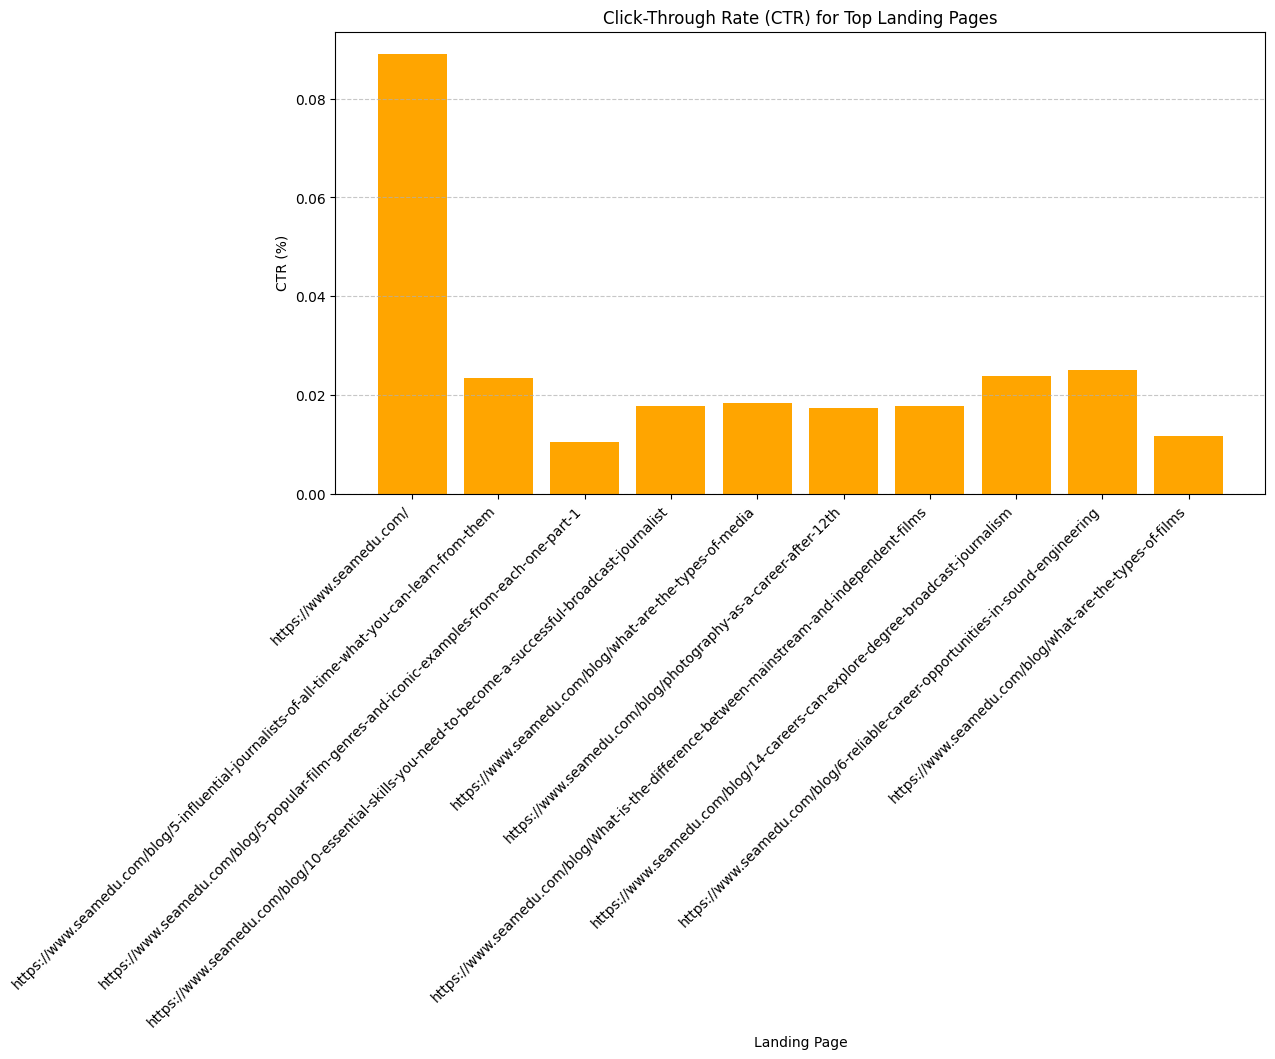

In [ ]:
# Bar chart for CTR (Click throufh rate), click/impressions
plt.figure(figsize=(12, 6))
plt.bar(top_pages['Top pages'], top_pages['CTR'], color='orange')
plt.title('Click-Through Rate (CTR) for Top Landing Pages')
plt.xlabel('Landing Page')
plt.ylabel('CTR (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Extracting the 3rd party data from 'Google Trends'**

In [ ]:
# 3P Data Integration
pytrends = TrendReq()                                                            #pytrends is a function used for extracting the data from google trends.
pytrends.build_payload(kw_list=['admission season'], timeframe='2023-12-20 2024-12-19')   #Search: Admission Season, Duration: 1 year, Worldwide.
trends_data = pytrends.interest_over_time().reset_index()
if not trends_data.empty:
    # Save the data to a CSV file
    trends_data.to_csv('google_trends_admission_season_2023_2024.csv')           #Saving the extracted data to a csv file.
    print("Data extracted successfully.")
else:
    print("No data available for the specified parameters.")

trends_data['admission season'] = trends_data['admission season'].interpolate(method='linear')

Data extracted successfully.


In [ ]:
print(trends_data.info())                                                        #Checking for null values or repeated values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              53 non-null     datetime64[ns]
 1   admission season  53 non-null     int64         
 2   isPartial         53 non-null     bool          
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 1.0 KB
None


In [ ]:
print(trends_data.head())
print(trends_data.shape)

        date  admission season  isPartial
0 2023-12-17                43      False
1 2023-12-24                50      False
2 2023-12-31                72      False
3 2024-01-07                69      False
4 2024-01-14                67      False
(53, 3)


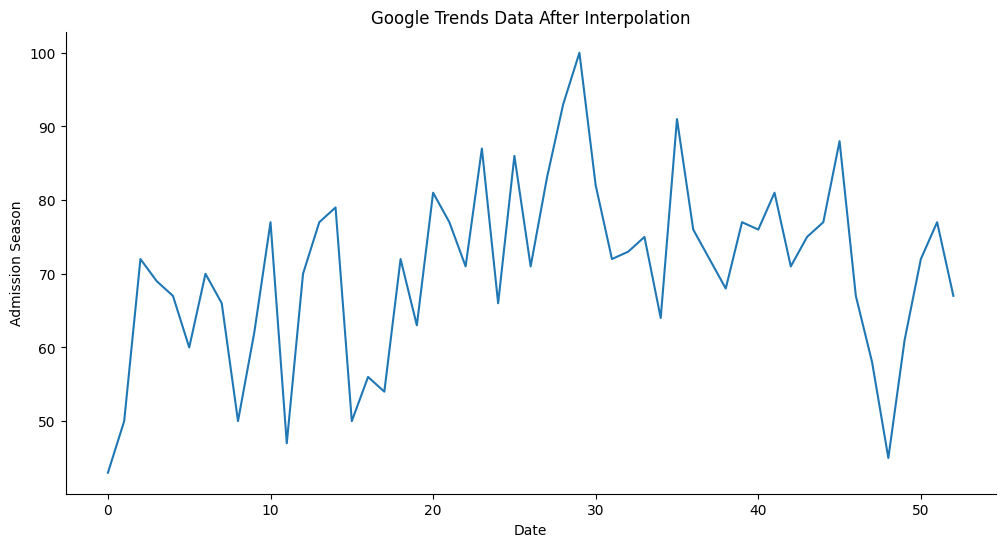

In [ ]:
# Plotting the extracted data after interpolation
plt.figure(figsize=(12, 6))
trends_data['admission season'].plot(title='Google Trends Data After Interpolation', ylabel='Admission Season', xlabel='Date')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [ ]:
# Merge the 1st Party and 3rd party Data
combined_data = pd.merge(date, trends_data, left_on='Date', right_on='date', how='inner').drop(columns=['date'])

In [ ]:
combined_data.head()

,Date,Clicks,Impressions,CTR,Position,WoW_Clicks,MoM_Clicks,YoY_Clicks,Month,WoW_Impressions,MoM_Impressions,YoY_Impressions,admission season,isPartial
0,2023-12-24,121,9616,0.0126,27.19,NaN,NaN,NaN,2023-12,NaN,NaN,NaN,50,False
1,2023-12-31,113,9933,0.0114,26.18,-0.066116,NaN,NaN,2023-12,0.032966,NaN,NaN,72,False
2,2024-01-07,206,12827,0.0161,23.88,0.823009,NaN,NaN,2024-01,0.291352,NaN,NaN,69,False
3,2024-01-14,186,13416,0.0139,23.87,-0.097087,NaN,NaN,2024-01,0.045919,NaN,NaN,67,False
4,2024-01-21,191,13495,0.0142,21.50,0.026882,0.44697,NaN,2024-01,0.005888,0.35669,NaN,60,False


CORRELATION ANALYSIS

In [ ]:
# Correlation Analysis of the extracted features.
correlation_columns = ['Clicks', 'Impressions', 'CTR', 'Position', 'WoW_Clicks', 'MoM_Clicks',
                       'YoY_Clicks', 'WoW_Impressions', 'MoM_Impressions', 'admission season']
correlation_matrix = combined_data[correlation_columns].corr()                   #corr() function used to find the correlatoion between the features.

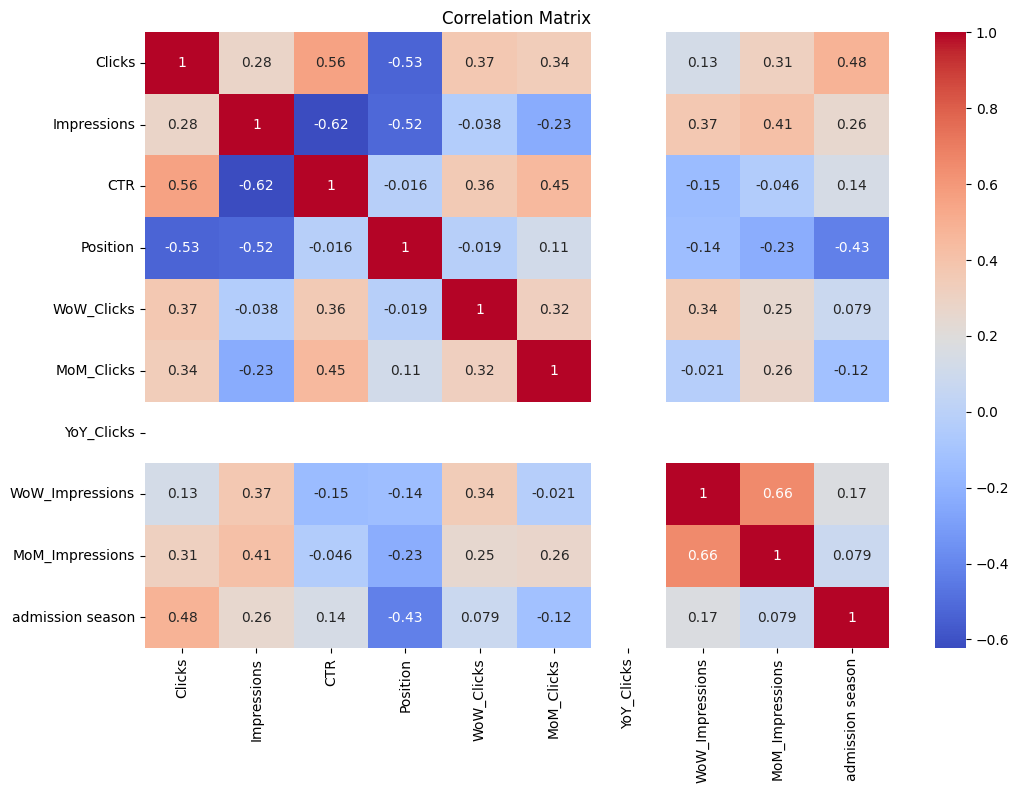

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

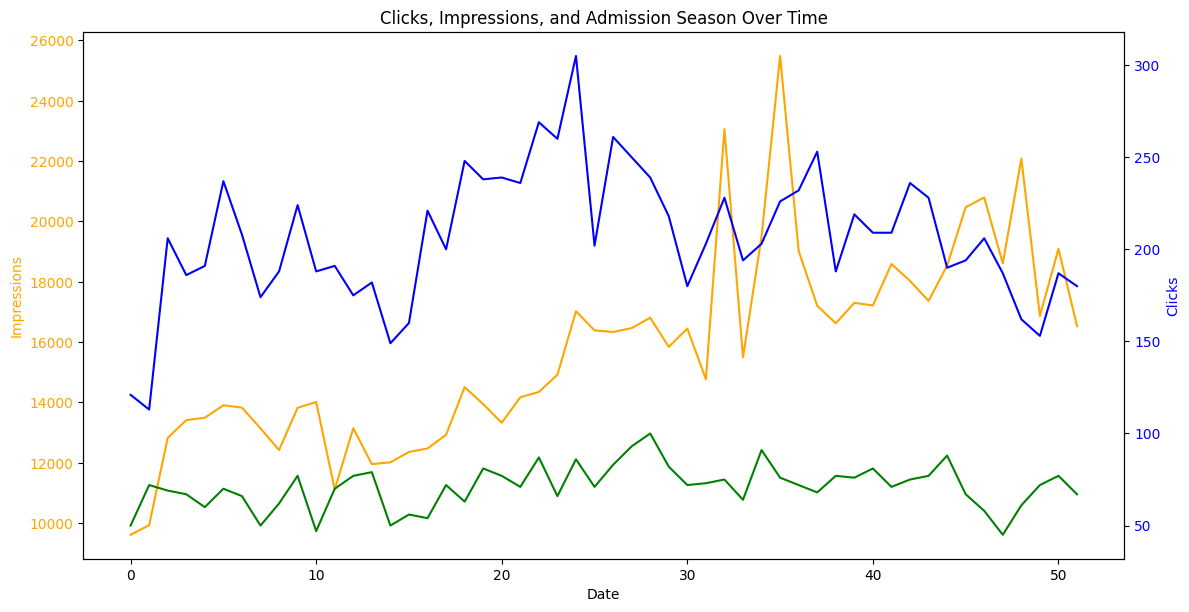

In [ ]:
#Plotting the clicks, impressions and admissions over time(Months)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Impressions on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Impressions', color='orange')
ax1.plot(combined_data.index, combined_data['Impressions'], color='orange', label='Impressions')
ax1.tick_params(axis='y', labelcolor='orange')

# Create a second y-axis for Clicks and admission season
ax2 = ax1.twinx()
ax2.set_ylabel('Clicks', color='blue')
ax2.plot(combined_data.index, combined_data['Clicks'], color='blue', label='Clicks')
ax2.plot(combined_data.index, combined_data['admission season'], color='green', label='Admission Season')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a legend
fig.tight_layout()  # Prevent overlap
plt.title('Clicks, Impressions, and Admission Season Over Time')
plt.show()

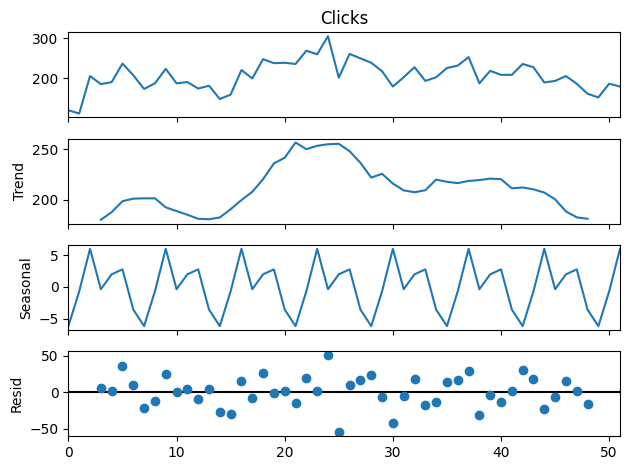

In [ ]:
# Seasonal Decomposition
decomposition = seasonal_decompose(combined_data['Clicks'], model='additive', period=7)
decomposition.plot()
plt.show()

**BUILDING A PREDICTIVE MODEL**

In [ ]:
# Predictive Modeling
X = combined_data[['admission season', 'CTR', 'Impressions']]
y = combined_data['Clicks']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   #Splitting the dataset for training and testing on 80 and 20 ratio

Linear Regression

In [ ]:
# Linear Regression
lr_model = LinearRegression()                                                   #importing linear regression model from sklearn.
lr_model.fit(X_train, y_train)                                                  #Fitting the dataset into the model
y_pred = lr_model.predict(X_test)
print("Linear Regression R-squared:", r2_score(y_test, y_pred))                 #error analysis using r-square- the more closer to 1, the more accurate results.

Linear Regression R-squared: 0.9114385615207743


In [ ]:
# Calculating RMSE
mse = mean_squared_error(y_test, y_pred)                                         #error analysis using- Root Mean Square.
rmse = np.sqrt(mse)                                                              #more closer to 1, the most accurate
print("Linear Regression RMSE:", rmse)                                           #ranges between 1 to 100

Linear Regression RMSE: 6.1359837437450055


Ridge Regression

In [ ]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)                                                   #importing ridge regression model from sklearn.
ridge_model.fit(X_train, y_train)                                                #Fitting the dataset into the model
ridge_pred = ridge_model.predict(X_test)
print("Ridge Regression R-squared:", r2_score(y_test, ridge_pred))              #error analysis using r-square- the more closer to 1, the more accurate results.

Ridge Regression R-squared: 0.17807620851717443


In [ ]:
# Calculate RMSE manually
ridge_mse = mean_squared_error(y_test, ridge_pred)                                 #error analysis using- Root Mean Square.
ridge_rmse = np.sqrt(ridge_mse)                                                    #more closer to 1, the most accurate
print("Ridge Regression RMSE:", ridge_rmse)

Ridge Regression RMSE: 20.546113413709712


Lasso Regression

In [ ]:
# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
print("Lasso Regression R-squared:", r2_score(y_test, lasso_pred))

Lasso Regression R-squared: 0.17792608595269732


In [ ]:
# Calculate RMSE manually
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
print("Lasso Regression RMSE:", lasso_rmse)

Lasso Regression RMSE: 20.54798967914892


**WE CONCLUDE LINEAR REGRESSION WORKS BEST AMOUNG OTHER MODELS,

Since the dataset is small and on considering the complexity of the dataset linear regression is the good model to use**

Predicting the values using linear regression trained model.

To understand the influence of each feature on Clicks.

In [ ]:
print("Feature Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"{feature}: {coef}")

Feature Coefficients:
admission season: 0.19808753245075444
CTR: 15211.280915524567
Impressions: 0.010889514536756906


Simulate various scenarios to understand the relationship between features and Clicks

In [ ]:
#we can use this model to understand how do Clicks change with a 10% increase in Impressions?
scenario_data = X_test.copy()
scenario_data['Impressions'] *= 1.1
scenario_predictions = lr_model.predict(scenario_data)

# Compare original vs scenario predictions
print("Original Predictions Mean:", y_pred.mean())
print("Scenario Predictions Mean:", scenario_predictions.mean())

Original Predictions Mean: 206.41738096630505
Scenario Predictions Mean: 223.84367308830372


Use the model to identify optimal Impressions or CTR needed to achieve a target number of Clicks.

In [ ]:
#we can predict the optimal CTR to achieve the intrested number of clicks over a period.

# Define target Clicks and function to minimize
target_clicks = 5000

def optimize_ctr(ctr):
    test_data = pd.DataFrame({
        'admission season': [50],  # Example value
        'CTR': [ctr],             # Variable to optimize
        'Impressions': [20000]    # Example value
    })
    pred_clicks = lr_model.predict(test_data)[0]
    return abs(pred_clicks - target_clicks)

# Optimize CTR to achieve target clicks
result = minimize(optimize_ctr, x0=0.02, bounds=[(0.01, 0.05)])  # Example bounds for CTR
print("Optimal CTR to achieve target Clicks:", result.x)

Optimal CTR to achieve target Clicks: [0.05]


**WE CAN USE THESE PREDICTIVE MODELS FOR VARIOUS APPLICATIONS IN THE DIGITAL MARKETING INDUSTRIES**